## 03 - Generate CCI data cubes 
### A DeepESDL example notebook 

This notebook demonstrates how to access CCI data via two dedicated xcube stores, which provide dynamic data cube views into each gridded data set. More information on the data sets offered can be found in the [Open Data Portal](https://climate.esa.int/en/odp/#/dashboard) of the [ESA Climate Change Initiative](https://climate.esa.int/en/esa-climate/esa-cci/) (CCI).

The xcube data store `cciodp` provides direct access to the datasets of the Open Data Portal. On the other hand, the xcube data store `ccizarr` is a subset of the `cciodp` store and contains CCI data that is already available in cloud-ready format, resulting in better data access performance. The store is regularly updated with new data. Details on the functionality of the two data stores can be found in the [xcube documentation](https://xcube.readthedocs.io/en/latest/dataaccess.html#esa-climate-data-centre-cciodp).

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2024

-----------------

**This notebook runs with the python environment `deepesdl-xcube-1.4.1`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

In [1]:
# mandatory imports
import datetime

import matplotlib.pyplot as plt

# Utilities for notebook visualization
import shapely.geometry
from IPython.display import JSON
from xcube.core.store import (
    find_data_store_extensions,
    get_data_store_params_schema,
    new_data_store,
)

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16, 8

### 1. xcube data store `cciodp`

Check whether the `cciodp` store is among the available stores, if not please follow the installation information from the top of this notebook. 

In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

/home/conda/deepesdl/cf7ebab7e67256aadc026f6b16fdaf2c2168f8fa9a61a0e89fdebfc318aea481-20240403-153123-176384-419-xcube-1.4.1/lib/python3.11/site-packages/xcube/util/plugin.py:186: UserWarning: Initializing xcube plugin 'xcube_cmems' took 170 ms, consider code optimization. (For example, avoid eager import of packages, consider lazy loading of resources, etc.)
  warnings.warn(


<IPython.core.display.JSON object>

Usually we need more information to get the actual data store object. Which data store parameters are available for `cciodp`? 

In [4]:
get_data_store_params_schema("cciodp")

Provide mandatory parameters to instantiate the store class:

In [5]:
odp_store = new_data_store("cciodp")

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [6]:
odp_store.list_data_ids()

['esacci.AEROSOL.5-days.L3C.AEX.GOMOS.Envisat.AERGOM.3-00.r1',
 'esacci.AEROSOL.climatology.L3.AAI.multi-sensor.multi-platform.MSAAI.1-7.r1',
 'esacci.AEROSOL.day.L3.AAI.multi-sensor.multi-platform.MSAAI.1-7.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.ADV.2-31.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.ORAC.04-01-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.ORAC.04-01_seg-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.SU.4-3.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.ADV.2-31.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.ORAC.04-01-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.ORAC.04-01_seg-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.SU.4-3.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.multi-sensor.multi-platform.AATSR-ENVISAT-ENS_DAILY.v2-6.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.multi-sensor.multi-platform.ATSR2-ENVISAT-ENS_DAILY.v2-6.r1',
 'esacci.AEROSOL.day.L3C.AOD.MERIS.Envisat.MERI

We may ask for a specific dataset ...

In [7]:
odp_store.has_data(
    "esacci.OC.5-days.L3S.CHLOR_A.multi-sensor.multi-platform.MERGED.3-1.geographic"
)

False

... but in many cases we want to query for certain criteria. How can we do that?

In [8]:
odp_store.get_search_params_schema()

Now search, let's search for sea surface temperature data (SST) with a daily frequency: 

In [9]:
iterator = odp_store.search_data(
    cci_attrs=dict(ecv="SST", frequency="day", processing_level="L4")
)
JSON([item.to_dict() for item in iterator])

/home/conda/deepesdl/cf7ebab7e67256aadc026f6b16fdaf2c2168f8fa9a61a0e89fdebfc318aea481-20240403-153123-176384-419-xcube-1.4.1/lib/python3.11/site-packages/xcube_cci/cciodp.py:1276: CciOdpWarning: Variable "field_name" has no fill value, cannot set one. For parts where no data is available you will see random values. This is usually the case when data is missing for a time step.
  warnings.warn(f'Variable "{fixed_key}" has no fill value, '


<IPython.core.display.JSON object>

Which parameters must be passsed or are available to open the dataset? 

In [10]:
odp_store.get_open_data_params_schema(
    "esacci.SST.day.L4.SSTdepth.multi-sensor.multi-platform.OSTIA.2-1.sst"
)

There are no required parameters, so we can decide what parameters we would like to provide them to open a dataset:

In [11]:
odp_dataset = odp_store.open_data(
    "esacci.SST.day.L4.SSTdepth.multi-sensor.multi-platform.OSTIA.2-1.sst",
    variable_names=["analysed_sst"],
    time_range=["1981-08-31", "2016-12-31"],
)

Plot one time stamp of the dataset for a analysed_sst in order to take a brief look at the dataset:  

In [12]:
odp_dataset

<xarray.Dataset> Size: 3TB
Dimensions:       (time: 12907, lat: 3600, lon: 7200, bnds: 2)
Coordinates:
  * lat           (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
    lat_bnds      (lat, bnds) float32 29kB dask.array<chunksize=(3600, 2), meta=np.ndarray>
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    lon_bnds      (lon, bnds) float32 58kB dask.array<chunksize=(7200, 2), meta=np.ndarray>
  * time          (time) datetime64[ns] 103kB 1981-08-31T12:00:00 ... 2016-12...
    time_bnds     (time, bnds) datetime64[ns] 207kB dask.array<chunksize=(12907, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    analysed_sst  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.SST.day.L4.SSTdepth.multi-sensor.multi-pl...
    date_created:            2024-04-04T09:01:48.191800
    processing_level:        L4
    time_coverage_start:     1981-08-31T00:00:00
    time_coverage_end:       2017-01-01T00:00:00
    time_coverage_duration:  P12907DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

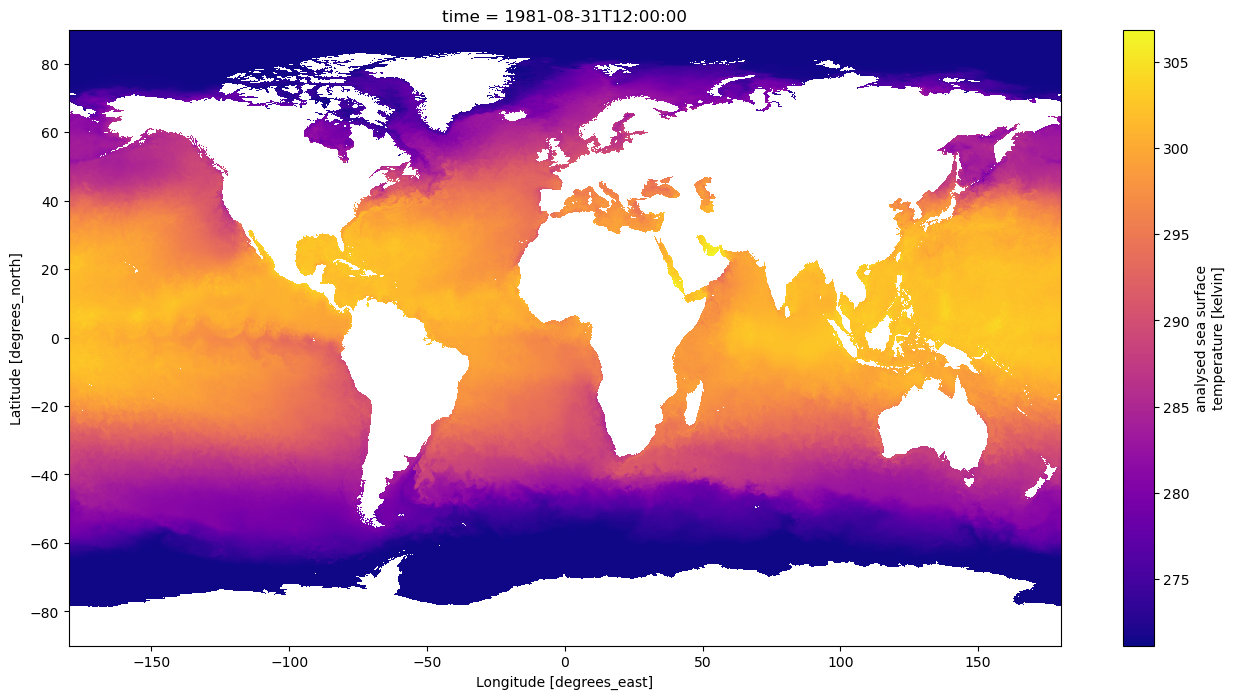

In [13]:
odp_dataset.analysed_sst.isel(time=0).plot.imshow(cmap="plasma")

### 2. xcube data store `ccizarr`

**Some of the CCI data is already available in a cloud-ready format, and new data is added on a regular basis. To access this data, select the `ccizarr` store instead of the `cciodp` store.**

In [14]:
zarr_store = new_data_store("ccizarr")

In [15]:
zarr_store.list_data_ids()

['ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-OCO-2-FOCAL-2014-2021-v10.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2020-fv2.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-1992-09-fv2.0.1.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_DAY-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_NIGHT-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_DAY-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_NIG

The data store ccizarr has no dedicated data store parameters. The dataset must be opened as a whole, temporal and spatial subsets can follow afterwards.

In [16]:
dataset = zarr_store.open_data(
    "ESACCI-OC-L3S-IOP-MERGED-1M_MONTHLY_4km_GEO_PML_OCx_QAA-1997-2020-fv5.0.zarr"
)

In [17]:
dataset

<xarray.Dataset> Size: 2TB
Dimensions:           (time: 280, lat: 4320, lon: 8640)
Coordinates:
  * lat               (lat) float64 35kB 89.98 89.94 89.9 ... -89.94 -89.98
  * lon               (lon) float64 69kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 2kB 1997-09-04 ... 2020-12-01
Data variables: (12/55)
    MERIS_nobs_sum    (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    MODISA_nobs_sum   (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    OLCI_nobs_sum     (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    SeaWiFS_nobs_sum  (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    VIIRS_nobs_sum    (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    adg_412           (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    ...                ...
    bbp_490           (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    bbp_510           (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    bbp_560           (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    bbp_665           (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
    crs               (time) int32 1kB dask.array<chunksize=(16,), meta=np.ndarray>
    total_nobs_sum    (time, lat, lon) float32 42GB dask.array<chunksize=(16, 1080, 1080), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                       CF-1.7
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    catalogue_url:                     https://catalogue.ceda.ac.uk/uuid/88c2...
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    creation_date:                     Tue Feb  2 10:58:12 2021
    ...                                ...
    time_coverage_duration:            P1M
    time_coverage_end:                 19700101T000000Z
    time_coverage_resolution:          P1M
    time_coverage_start:               19700101T000000Z
    title:                             ESA CCI Ocean Colour Product
    tracking_id:                       95e99081-7011-4044-8f2b-d7db84276a4e

Get an overview of the parameter scheme of the datasets in the zarr_store and create subsets accordingly

In [18]:
zarr_store.get_open_data_params_schema(
    "ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr"
)

In [19]:
def open_zarrstore(filename, time_range, variables):
    ds = zarr_store.open_data(filename)
    subset = ds.sel(time=slice(time_range[0], time_range[1]))
    subset = subset[variables]

    return subset


zarr_dataset = open_zarrstore(
    "ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr",
    time_range=[datetime.datetime(1982, 1, 1), datetime.datetime(2016, 12, 31)],
    variables=["analysed_sst"],
)

In [20]:
zarr_dataset

<xarray.Dataset> Size: 106GB
Dimensions:       (time: 12783, lat: 720, lon: 1440)
Coordinates:
  * lat           (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time          (time) datetime64[ns] 102kB 1982-01-01T12:00:00 ... 2016-12...
Data variables:
    analysed_sst  (time, lat, lon) float64 106GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4
    acknowledgment:             Funded by ESA
    cdm_data_type:              grid
    comment:                    
    creator_email:              science.leader@esa-sst-cci.org
    creator_name:               SST_cci
    ...                         ...
    summary:                    An ensemble product with input from a number ...
    time_coverage_end:          20170101T000000Z
    time_coverage_start:        20161231T000000Z
    title:                      Global SST Ensemble, L4 GMPE
    uuid:                       dc0c5b25-93bf-4943-aba1-7f0de9109620
    westernmost_longitude:      -180.0

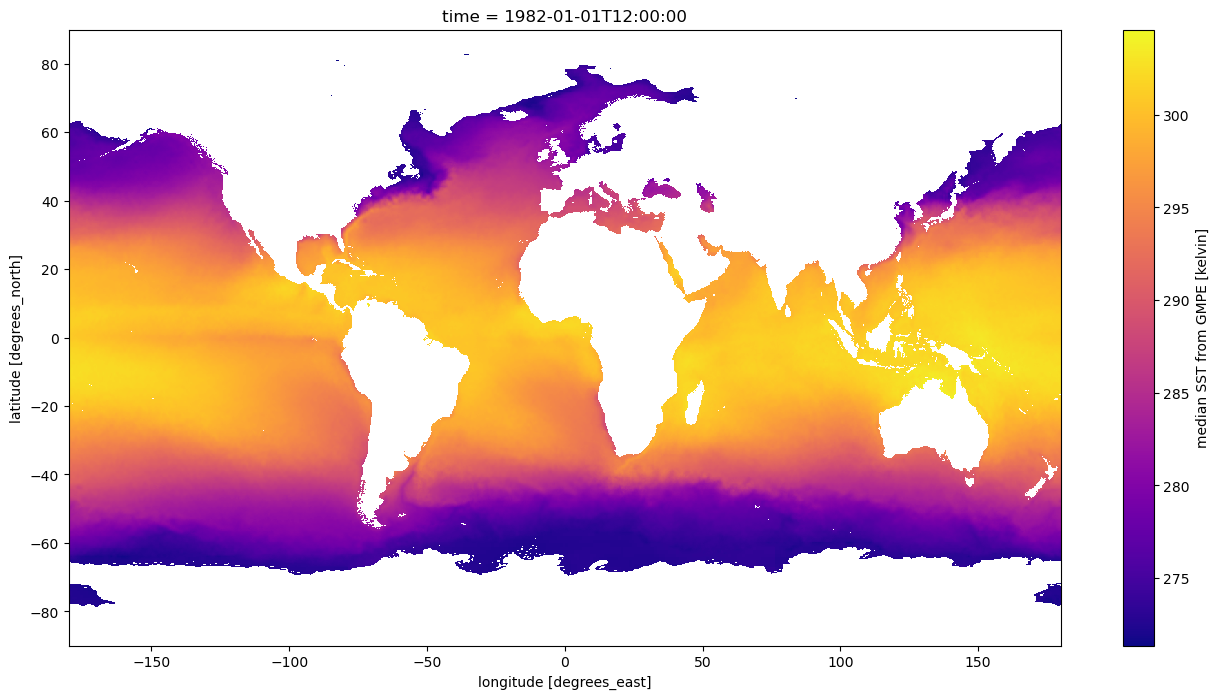

In [21]:
zarr_dataset.analysed_sst.isel(time=0).plot.imshow(cmap="plasma")